<a href="https://colab.research.google.com/github/pswaruppk/GL_CAPSTONE/blob/master/pneumonia_option_1_detection_retinanet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retinanet based detection model

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"

# os.chdir(project_path)
# os.getcwd()
# # os.removedirs('keras-retinanet')

#Local parameter setup

In [3]:
#Set global parameters here
BASE_MODEL = "Retinanet"
MODEL_NAME  = "/content/drive/My Drive/Option-1" + "." + BASE_MODEL
saved_model_file = MODEL_NAME + '/' + 'model_2.h5'
if os.path.isdir(MODEL_NAME) == False:
  os.mkdir(MODEL_NAME)

HISTORY_FILE = MODEL_NAME+"/" +"history.csv"
BATCH_SIZE = 16
IMAGE_SIZE = 256 #target image width
IMG_WIDTH = 1024 #Original image width
FORCE_TRAINING = True #True , change it to force training
EPOCHS = 2

In [4]:
oldPath = os.getcwd()
utility_path = "/content/drive/My Drive/GL_CAPSTONE"
os.chdir(utility_path)
%run pneumonia_utility.ipynb
# baseModel,preprocess_input = selectBaseModel(BASE_MODEL)
os.chdir(oldPath)
print(os.getcwd())
# print(baseModel,preprocess_input)

Loading functions from Pneumonia utility notebook
Loading pydicom package
     |████████████████████████████████| 35.5MB 1.2MB/s 
/content


#Retina net setup

In [5]:
!nvidia-smi

Mon Sep 21 15:21:07 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.66       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   61C    P0    29W /  70W |    229MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [5]:
#setup retinanet environment
os.chdir("/content/")
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 6112 (delta 7), reused 6 (delta 6), pack-reused 6103
Receiving objects: 100% (6112/6112), 13.45 MiB | 29.06 MiB/s, done.
Resolving deltas: 100% (4130/4130), done.


In [6]:
!pip install --upgrade keras

Requirement already up-to-date: keras in /usr/local/lib/python3.6/dist-packages (2.4.3)


In [7]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp36-cp36m-linux_x86_64.whl size=168094 sha256=4087560f94e6338e939a09f3b86aaec4bd4f6d87139e77249cddd366bea0ef31
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=55ce82e6a1b30233814a2e8853d69d5d9d084d864a22a6f1f62284acdaa62a74
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [8]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [9]:
# !pip install gdown
# !pip install tensorflow-gpu

In [10]:
import numpy as np
import tensorflow as tf
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from pandas.plotting import register_matplotlib_converters
from sklearn.model_selection import train_test_split
import urllib
import os
import csv
import cv2
import time
from PIL import Image

from keras_retinanet import models
from keras_retinanet.utils.image import read_image_bgr, preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

%matplotlib inline
%config InlineBackend.figure_format='retina'

register_matplotlib_converters()
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize'] = 15, 7

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)
tf.random.set_seed(RANDOM_SEED)

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Prepare  training data

In [11]:
# Load bounding boxes & merged data
oldPath = os.getcwd()
os.chdir(project_path)
meta_data, bbox_map, class_enc = loadData()

os.chdir(oldPath)

Loading full CXR info
Loading bbox map


In [12]:
#cleare class encoding
classes = []
# classes.append('NO_PNEUMONIA')
classes.append('PNEUMONIA')
CLASSES_FILE = MODEL_NAME + '/classes.csv'
with open(CLASSES_FILE, 'w') as f:
  for i, line in enumerate(classes):
    f.write('{},{}\n'.format(line,i))

In [13]:
#create local copy for training
import shutil
shutil.copy(CLASSES_FILE, 'classes.csv')

'classes.csv'

In [14]:
#utility function to convert dicom to jpeg
#genrate annotation file
#generate class file
import csv
import cv2
import gc
import os
gc.enable() #To enable garbage collection automatically
def convertToJpg(pn_df,annotationFile):
  # if (os.path.exists(annotationFile)):
  #   os.remove(annotationFile)
  csvFile = open(annotationFile, 'w', newline ='')
  csv_writer = csv.writer(csvFile, delimiter=',')
  folder = 'stage_2_train_images'
  folder_jpg = MODEL_NAME + '/' + folder
  if (os.path.isdir(folder_jpg) == False):
    os.mkdir(folder_jpg)
  folder_dcm = project_path + '/'+ folder
  i = 0;
  length = pn_df.shape[0]
  den= int(length/50)
  for n, row in pn_df.iterrows():
    if (i%den == 0):
      print("Converting jpg:{} of {}".format(i,length))
    i +=1
    
    pid = row['patientId']
    
    dcm_path = folder_dcm + '/' +pid +'.dcm'
    #Add csv annotation row for the image
    jpg_path = folder_jpg+'/'+pid +'.jpg'
    x1,x2,y1,y2= ['','','','']
    class_name = ''
    if pid in bbox_map:
      bboxes = bbox_map[pid].get('bboxes')
      for bb in bboxes:
        y, x, h, w = bb
        x1 = int(x)
        y1 = int(y)
        x2 = int(x1 + int(w))
        y2 = int(y1 + int(h))
        class_name = 'PNEUMONIA'
        csv_row = [jpg_path,x1,y1,x2,y2,class_name]
        csv_writer.writerow(csv_row)
    else:
      csv_row = [jpg_path,x1,y1,x2,y2,class_name]
      csv_writer.writerow(csv_row)
    #dump jpg if it does not exist
    if (os.path.exists(jpg_path) == False):
      # print(jpg_path)
      ds = pydicom.dcmread(dcm_path)
      pixel = ds.pixel_array
      cv2.imwrite(jpg_path,pixel)
      del ds

  csvFile.close()
  




In [15]:
# import pandas as pd
# target_csv = project_path +'/' + 'stage_2_train_labels.csv'
# df_target = pd.read_csv(target_csv)


In [16]:
col = meta_data.columns[0]
if (col == 'Unnamed: 0'):
  meta_data.drop(col, inplace=True,axis=1)
meta_data.sample(3)


,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
10189,6d25fc2c-d0b3-4b4b-850f-dea71042576a,NaN,NaN,NaN,NaN,0,1,60,1,0,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/6d25fc2c-d0b3-4b4b-850f-d...
19102,b2541f48-1acf-4f33-b604-8665fc1517c8,179.0,581.0,169.0,183.0,1,2,59,0,1,Lung Opacity,0,"[1.0, 0.0, 0.0]",stage_2_train_images/b2541f48-1acf-4f33-b604-8...
25427,e3d0271b-b53f-4d6b-9e99-57fab7644798,NaN,NaN,NaN,NaN,0,1,32,1,1,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/e3d0271b-b53f-4d6b-9e99-5...


In [17]:
meta_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30227 entries, 0 to 30226
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   patientId     30227 non-null  object 
 1   x             9555 non-null   float64
 2   y             9555 non-null   float64
 3   width         9555 non-null   float64
 4   height        9555 non-null   float64
 5   Target        30227 non-null  int64  
 6   BboxNo        30227 non-null  int64  
 7   PatientAge    30227 non-null  int64  
 8   PatientSex    30227 non-null  int64  
 9   ViewPosition  30227 non-null  int64  
 10  class         30227 non-null  object 
 11  class_id      30227 non-null  int64  
 12  class_vector  30227 non-null  object 
 13  path          30227 non-null  object 
dtypes: float64(4), int64(6), object(4)
memory usage: 3.2+ MB


In [18]:
#split the data
df_target = meta_data
raw_train_df,test_df = train_test_split(df_target, test_size=0.20, random_state=11,
                                    stratify=df_target['Target'])

In [19]:
print(raw_train_df.shape, ':training data')
print(test_df.shape, ':test data')
print('{}: train PNEUMONIA'.format(raw_train_df[raw_train_df.Target == 1].shape))
print('{}: test PNEUMONIA'.format(test_df[test_df.Target == 1].shape))
print('{}: full PNEUMONIA'.format(df_target[df_target.Target == 1].shape))

(24181, 14) :training data
(6046, 14) :test data
(7644, 14): train PNEUMONIA
(1911, 14): test PNEUMONIA
(9555, 14): full PNEUMONIA


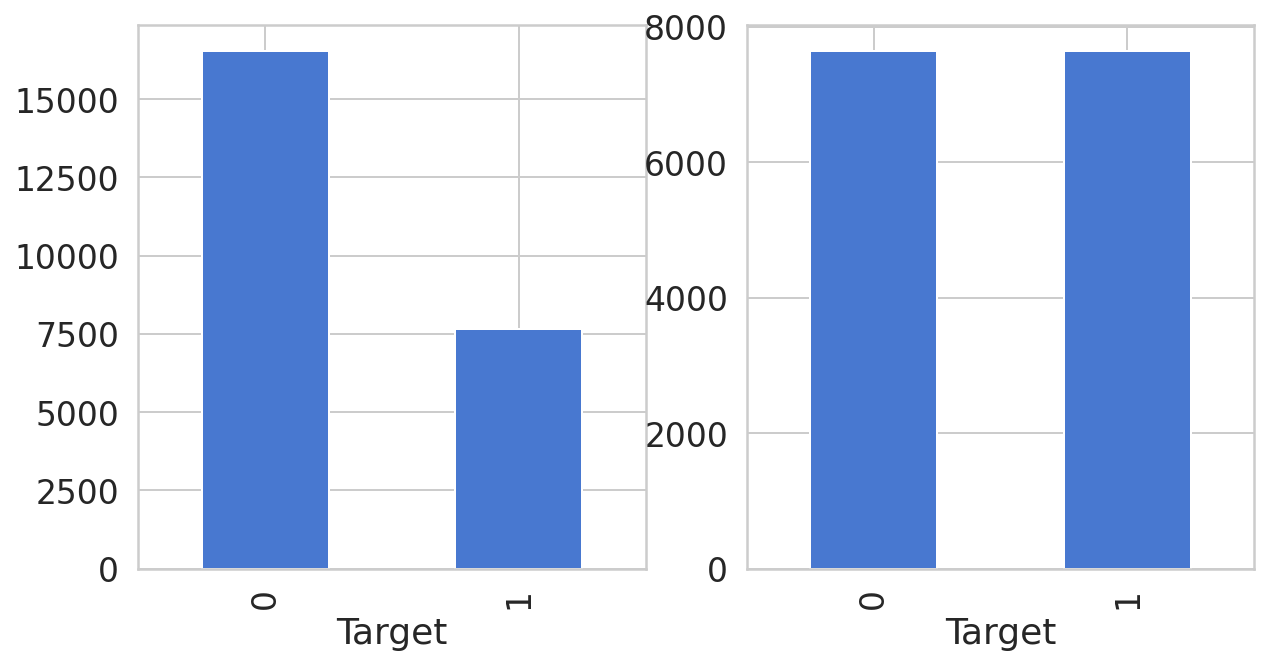

In [21]:
train_df = balance_df(raw_train_df,15288)

In [82]:
%%time
os.chdir("/content/keras-retinanet")
#create annotation file & convert to JPEG
ANNOTATIONS_FILE = MODEL_NAME + '/annotations.csv'
if (os.path.isfile(ANNOTATIONS_FILE) == False):
  convertToJpg(train_df.sample(1000),ANNOTATIONS_FILE)

Converting jpg:0 of 1000
Converting jpg:20 of 1000
Converting jpg:40 of 1000
Converting jpg:60 of 1000
Converting jpg:80 of 1000
Converting jpg:100 of 1000
Converting jpg:120 of 1000
Converting jpg:140 of 1000
Converting jpg:160 of 1000
Converting jpg:180 of 1000
Converting jpg:200 of 1000
Converting jpg:220 of 1000
Converting jpg:240 of 1000
Converting jpg:260 of 1000
Converting jpg:280 of 1000
Converting jpg:300 of 1000
Converting jpg:320 of 1000
Converting jpg:340 of 1000
Converting jpg:360 of 1000
Converting jpg:380 of 1000
Converting jpg:400 of 1000
Converting jpg:420 of 1000
Converting jpg:440 of 1000
Converting jpg:460 of 1000
Converting jpg:480 of 1000
Converting jpg:500 of 1000
Converting jpg:520 of 1000
Converting jpg:540 of 1000
Converting jpg:560 of 1000
Converting jpg:580 of 1000
Converting jpg:600 of 1000
Converting jpg:620 of 1000
Converting jpg:640 of 1000
Converting jpg:660 of 1000
Converting jpg:680 of 1000
Converting jpg:700 of 1000
Converting jpg:720 of 1000
Convert

In [83]:
shutil.copy(ANNOTATIONS_FILE, 'annotations.csv')

'annotations.csv'

In [24]:
!ls

annotations.csv  CONTRIBUTORS.md  keras_retinanet  requirements.txt  snapshots
build		 examples	  LICENSE	   setup.cfg	     tests
classes.csv	 images		  README.md	   setup.py


In [25]:
!pwd

/content/keras-retinanet


In [26]:
with open(ANNOTATIONS_FILE) as f: 
  cf = csv.reader(f) 
  for row in cf: 
    print(row)
    break

['/content/drive/My Drive/Option-1.Retinanet/stage_2_train_images/58e38024-ca19-4410-b4b2-0230b1cf7320.jpg', '', '', '', '', '']


In [84]:
annot = pd.read_csv(ANNOTATIONS_FILE,header=None)
annot.columns = ["image_name","x_min","y_min","x_max","y_max","class_name"]

In [85]:
annot.sample(5)

,image_name,x_min,y_min,x_max,y_max,class_name
916,/content/drive/My Drive/Option-1.Retinanet/sta...,NaN,NaN,NaN,NaN,NaN
1150,/content/drive/My Drive/Option-1.Retinanet/sta...,205.0,476.0,448.0,750.0,PNEUMONIA
639,/content/drive/My Drive/Option-1.Retinanet/sta...,641.0,623.0,828.0,778.0,PNEUMONIA
690,/content/drive/My Drive/Option-1.Retinanet/sta...,591.0,471.0,788.0,725.0,PNEUMONIA
31,/content/drive/My Drive/Option-1.Retinanet/sta...,203.0,254.0,375.0,465.0,PNEUMONIA


In [86]:
annot.shape

(1397, 6)

In [30]:
#display sample image
def show_image_objects(image_row):

  img_path = image_row.image_name
  box = [
    image_row.x_min, image_row.y_min, image_row.x_max, image_row.y_max
  ]

  image = read_image_bgr(img_path)

  draw = image.copy()
  draw = cv2.cvtColor(draw, cv2.COLOR_BGR2RGB)

  draw_box(draw, box, color=(255, 255, 0))

  plt.axis('off')
  plt.imshow(draw)
  plt.show()
  

In [31]:
# pnu_annot = annot[annot.class_name == "PNEUMONIA"].sample(900)

# pnu_annot.x_min = pnu_annot.x_min.astype('int')
# pnu_annot.y_min = pnu_annot.y_min.astype('int')
# pnu_annot.x_max = pnu_annot.x_max.astype('int')
# pnu_annot.y_max = pnu_annot.y_max.astype('int')
# pnu_annot.to_csv('annotations.csv',index=False, header=None)

In [32]:
# pnu_annot.info()

In [33]:
index = annot[annot.class_name == "PNEUMONIA"].head().iloc[3]

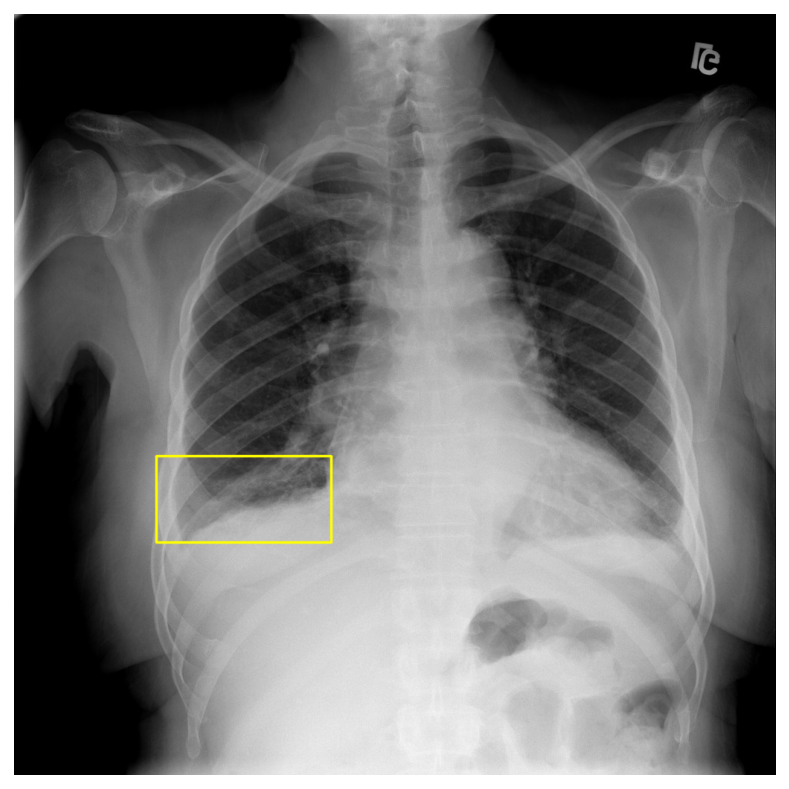

In [35]:
show_image_objects(index)

#Training retinanet

In [ ]:
!retinanet-train --help

2020-09-20 20:22:11.693401: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
usage: retinanet-train [-h]
                       [--snapshot SNAPSHOT | --imagenet-weights | --weights WEIGHTS | --no-weights]
                       [--backbone BACKBONE] [--batch-size BATCH_SIZE]
                       [--gpu GPU] [--multi-gpu MULTI_GPU] [--multi-gpu-force]
                       [--initial-epoch INITIAL_EPOCH] [--epochs EPOCHS]
                       [--steps STEPS] [--lr LR]
                       [--optimizer-clipnorm OPTIMIZER_CLIPNORM]
                       [--snapshot-path SNAPSHOT_PATH]
                       [--tensorboard-dir TENSORBOARD_DIR]
                       [--tensorboard-freq TENSORBOARD_FREQ] [--no-snapshots]
                       [--no-evaluation] [--freeze-backbone]
                       [--random-transform] [--image-min-side IMAGE_MIN_SIDE]
                       [--image-max-side IMAGE_MAX_SIDE] 

In [36]:
import urllib
snapshot = MODEL_NAME + '/MYSNAPSHOT'
if (os.path.isdir(snapshot) == False):
  os.makedirs(snapshot,exist_ok=True)
PRETRAINED_MODEL = snapshot + '/pretrained_model.h5'
# PRETRAINED_MODEL = snapshot + '/weights_1'+ '/' + 'resnet101_csv_06.h5'
if (os.path.isfile(PRETRAINED_MODEL) == False):
  print('Loading initial resnet101')
# #### OPTION 1: DOWNLOAD INITIAL PRETRAINED MODEL FROM FIZYR ####
# # URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.0/resnet101_oid_v1.0.0.h5'
  URL_MODEL = 'https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet101_oid_v1.0.0.h5'
  urllib.request.urlretrieve(URL_MODEL, PRETRAINED_MODEL)

#### OPTION 2: DOWNLOAD CUSTOM PRETRAINED MODEL FROM GOOGLE DRIVE. CHANGE DRIVE_MODEL VALUE. USE THIS TO CONTINUE PREVIOUS TRAINING EPOCHS ####
#drive.mount('/content/gdrive')
#DRIVE_MODEL = '/content/gdrive/My Drive/Colab Notebooks/objdet_tensorflow_colab/resnet50_csv_10.h5'
PRETRAINED_MODEL_LOCAL = 'pretrained_model.h5'
# shutil.copy(WEIGHTS_FILE, PRETRAINED_MODEL_LOCAL)
shutil.copy(PRETRAINED_MODEL, PRETRAINED_MODEL_LOCAL)


print('Downloaded pretrained model to ' + PRETRAINED_MODEL_LOCAL)

Downloaded pretrained model to pretrained_model.h5


In [40]:
!ls snapshots

resnet101_csv_01.h5


In [37]:
WEIGHT_FILE = PRETRAINED_MODEL_LOCAL 
# WEIGHT_FILE = 'snapshots' + '/resnet101_csv_03.h5'
# !ls snapshots

In [87]:
%%time 
EPOCHS = 3
BATCH_SIZE =32
WEIGHT_FILE = 'snapshots/resnet101_csv_03.h5'
# if ((FORCE_TRAINING == True) | os.path.isfile(saved_model_file) == False):
  #back bone resnet101, resnet 152
  # batch size 16
  # --snapshot SNAPSHOT use this when to start training from here
  #--freeze-backbone --random-transform
  # --lr = 0.0001 --reduce-lr-patience =2 --reduce-lr-factor=0.2 epoch=6
  #  
                  #    --snapshot snapshots \
                  #  --initial-epoch 1 \
  # --lr 0.0001 --reduce-lr-patience 2 --reduce-lr-factor 0.2 \
  # !retinanet-train  --random-transform --snapshot snapshots --initial-epoch 3 --lr 0.0001 --reduce-lr-patience 2 --reduce-lr-factor 2 --backbone resnet101 --freeze-backbone  --weights {WEIGHT_FILE} --batch-size 32  --steps 600 --epochs 5 --image-max-side 512 --workers 6 --multiprocessing    csv annotations.csv classes.csv
!retinanet-train   --weights {WEIGHT_FILE} \
                   --backbone resnet101 --freeze-backbone  \
                   --batch-size {BATCH_SIZE} \
                   --steps 500 --epochs {EPOCHS} \
                   --image-max-side {IMAGE_SIZE} \
                   --workers 6 --multiprocessing \
                   csv annotations.csv classes.csv

2020-09-21 17:43:52.599051: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-09-21 17:50:39.762241: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-09-21 17:50:39.766906: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-09-21 17:50:39.767331: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla T4 computeCapability: 7.5
coreClock: 1.59GHz coreCount: 40 deviceMemorySize: 14.73GiB deviceMemoryBandwidth: 298.08GiB/s
2020-09-21 17:50:39.767394: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-09-21 17:50:39.769839: I t

# Inference

In [ ]:
!ls snapshots

In [ ]:
# src = './snapshots'
# if (os.path.isdir(src)):
#   dst = snapshot + '/' + 'weights_1'
#   shutil.copytree(src, dst)

In [ ]:
# model = models.load_model('/content/drive/My Drive/Option-1.Retinanet/model.h5')
# model.summary()

In [89]:
model = 0
os.chdir("/content/keras-retinanet")
if ((FORCE_TRAINING == False) & os.path.isfile(saved_model_file)):
# if (False):
  print("Loading saved model")
  model = models.load_model(saved_model_file)
  model.summary()
  print('Model Loading done')
else:
  model_path = os.path.join('snapshots', sorted(os.listdir('snapshots'), reverse=True)[0])
  # model_path = WEIGHTS_FILE
  print(model_path)

  model = models.load_model(model_path, backbone_name='resnet101')
  model = models.convert_model(model)
  print("Saving model at:",saved_model_file)
  model.save(saved_model_file)
  print('Model saving done')

labels_to_names = pd.read_csv(CLASSES_FILE, header=None).T.loc[0].to_dict()

snapshots/resnet101_csv_03.h5
Saving model at: /content/drive/My Drive/Option-1.Retinanet/model_2.h5
Model saving done


In [ ]:

# #del model
# model = models.load_model('/content/drive/My Drive/Option-1.Retinanet/model.h5')

In [ ]:
annot[annot.class_name == 'PNEUMONIA'].head().iloc[0].image_name

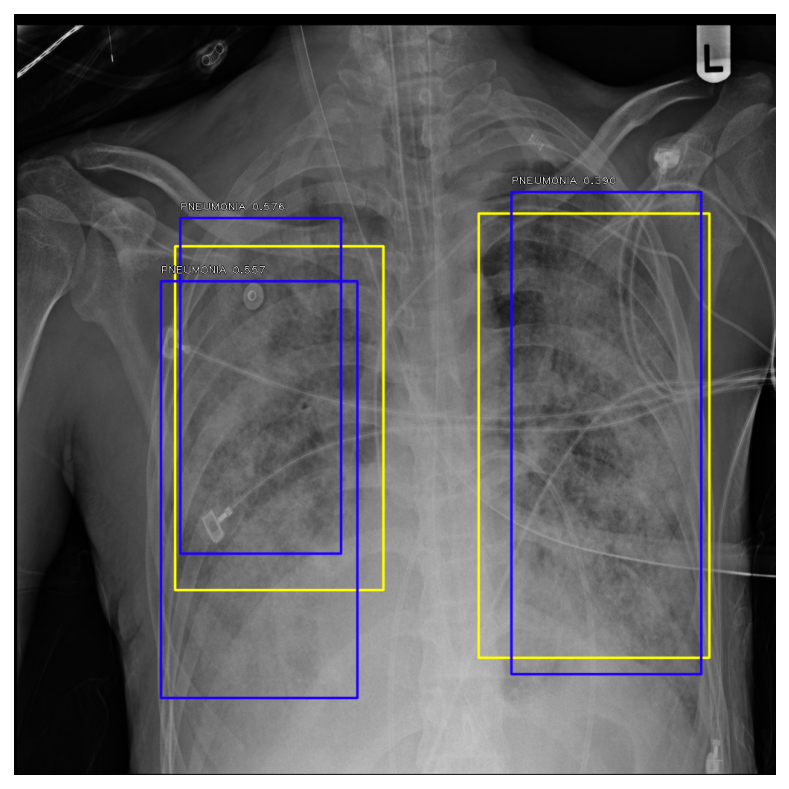

In [91]:
THRES_SCORE=0.3
oldPath = os.getcwd()
project_path = "/content/drive/My Drive/rsna-pneumonia-detection-challenge"
os.chdir(project_path)
folder = 'stage_2_train_images'
dcm_path = folder + '/' + 'cd1d42a0-e085-4f64-baaf-1da212416e8d.dcm'
# dcm_path = folder + '/' + '378ef52a-cbc7-4e92-bd6b-ecb4045508f3.dcm'
# dcm_path = folder + '/' + 'b8a633b3-b2fa-4e17-be54-faf0aba4c903.dcm'
show_detected_objects(dcm_path,bbox_map,model)
os.chdir(oldPath)

#Performance -Score/NMS filtering

In [44]:
test_df.head(1)

,patientId,x,y,width,height,Target,BboxNo,PatientAge,PatientSex,ViewPosition,class,class_id,class_vector,path
18993,b18e9b1c-e430-4200-8553-e585e0c49afc,NaN,NaN,NaN,NaN,0,1,43,1,0,Normal,2,"[0.0, 0.0, 1.0]",stage_2_train_images/b18e9b1c-e430-4200-8553-e...


/content/keras-retinanet


In [20]:
%%time
os.chdir(project_path)
iou = 0.3
THRES_SCORE=0.3
no_test = test_df.shape[0]
pred_file = MODEL_NAME + '/prediction.' +str(iou)+ str(no_test) +'.csv'
FORCE_PREDICTION = False;
pred_test_df = pd.DataFrame()
pred_test_df = 0
test_y = 0;
pred_y = 0
if ((os.path.isfile(pred_file) == False) | (FORCE_PREDICTION)):
  print('Predicting on test dataframe')
  #Pass test dataframe, bouding box map, trained mode, file to dump prediction, IoU threshold
  sample = test_df.sample(300)
  pred_test_df,test_y,pred_y = doRetinaPrediction(sample,bbox_map,model,pred_file,iou)
else:
  pred_test_df = pd.read_csv(pred_file)
  test_y = pred_test_df["Target"]
  pred_y = pred_test_df["predTarget"]

CPU times: user 6.19 ms, sys: 0 ns, total: 6.19 ms
Wall time: 341 ms


In [21]:
len(pred_test_df[pred_test_df.predTarget == 1])

201

In [23]:
pred_test_df.head(10)

,patientId,x,y,width,height,Target,x_pred,y_pred,width_pred,height_pred,predTarget,iou,confidence
0,9dc1d341-d3a7-4745-bd02-6c877d696bf2,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
1,9bad4ae2-1652-40bf-a1bf-d6613fa70766,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
2,93e36af8-ab53-487d-a486-3d0e0476bb84,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
3,bdb78a39-ecde-436d-90e7-9254fe934993,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
4,b6158255-d002-48a7-a283-af4ad2d8874a,219,566,176,159,1,212,549,170,194,1,0.739493,0.333612
5,b6158255-d002-48a7-a283-af4ad2d8874a,681,626,228,216,1,634,624,259,228,1,0.732578,0.382831
6,6aba46dc-7658-4f06-9711-b8e17f582c1c,0,0,0,0,0,0,0,0,0,0,0.000000,0.300000
7,3576b088-b3b9-40f2-bd44-de169e3e82f7,561,587,189,311,1,576,491,216,366,1,0.517088,0.592457
8,3576b088-b3b9-40f2-bd44-de169e3e82f7,561,587,189,311,1,608,661,155,211,1,0.487013,0.512976
9,3576b088-b3b9-40f2-bd44-de169e3e82f7,561,587,189,311,1,571,614,224,377,1,0.550227,0.498123


In [103]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(test_y, pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(test_y, pred_y))

Confusion Matrix:- 
 [[209   0]
 [ 39 201]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.84      1.00      0.91       209
           1       1.00      0.84      0.91       240

    accuracy                           0.91       449
   macro avg       0.92      0.92      0.91       449
weighted avg       0.93      0.91      0.91       449



In [104]:
filtered_df = pred_test_df.groupby('patientId').apply(lambda x: x[x.predTarget == 1].sample(1) if (x.predTarget.any()) else x.sample(1))

In [105]:
f_test_y = filtered_df["Target"]
f_pred_y = filtered_df["predTarget"]

In [106]:
f_test_y = f_test_y.apply(int)
f_pred_y = f_pred_y.apply(int)

In [107]:
print("Confusion Matrix:- \n", metrics.confusion_matrix(f_test_y, f_pred_y), "\n")
print("Classification Report:- \n", metrics.classification_report(f_test_y, f_pred_y))

Confusion Matrix:- 
 [[209   0]
 [ 13  78]] 

Classification Report:- 
               precision    recall  f1-score   support

           0       0.94      1.00      0.97       209
           1       1.00      0.86      0.92        91

    accuracy                           0.96       300
   macro avg       0.97      0.93      0.95       300
weighted avg       0.96      0.96      0.96       300

